# Generating Obsplans Automatically

In progress

## Step 1: Generate Airmass Grid

Note that the airmass values depend on temperature, pressure, and humidity at CTIO. The default location uses fiducial values of relative humidity = 0.5, temperature = 5 degrees Celsius, and pressure = 780 mbar, but these values should be updated and airmass grid recalculated at different times of the year.

In [1]:
from decat_obsplan_generator import AirmassCalculator

ac = AirmassCalculator()
ac.generate_airmass_grid()

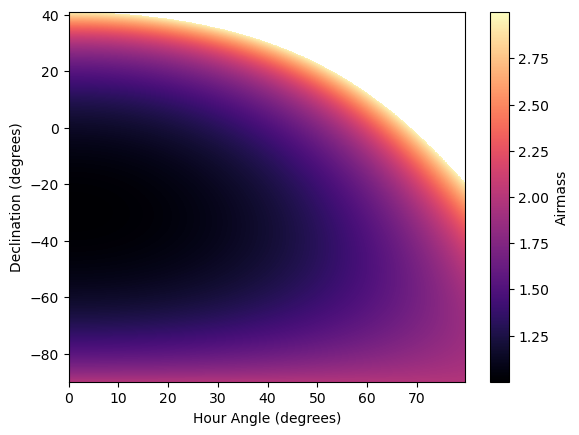

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# plot 2d airmass grid
airmass_grid = ac.load_airmass_grid()
airmass_grid.loc[airmass_grid.airmass > 3.0, "airmass"] = np.nan
pivot_table = airmass_grid.pivot(index="dec", columns="ha", values="airmass")
x_min, x_max = airmass_grid["ha"].min(), airmass_grid["ha"].max()
y_min, y_max = airmass_grid["dec"].min(), airmass_grid["dec"].max()

plt.imshow(
    pivot_table, cmap="magma", origin="lower", aspect="auto", extent=(x_min, x_max + 1, y_min, y_max + 1)
)
plt.colorbar(label="Airmass")  # Optional: Add a colorbar
plt.xlabel("Hour Angle (degrees)")
plt.ylabel("Declination (degrees)")
plt.show()

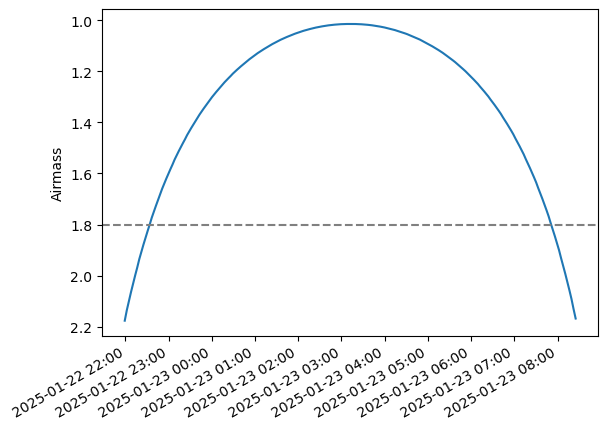

In [11]:
# generate airmass plot for random RA/dec
import astropy.units as u

fig, ax = plt.subplots()
ra_test = 100.0 * u.deg
dec_test = -40 * u.deg
ac.plot_airmass(fig, ax, ra_test, dec_test)
plt.show()

In [ ]:
# case 2: specific time ranges
from astropy.time import Time

fig, ax = plt.subplots()
ra_test = 100.0 * u.deg
dec_test = -40 * u.deg

times1 = Time.now() + np.linspace(0, 4.0, num=100) * u.hour
times2 = Time.now() + np.linspace(4.0, 8.0, num=100) * u.hour
times3 = Time.now() + np.linspace(-4.0, 0.0, num=100) * u.hour

ac.plot_airmass(fig, ax, ra_test, dec_test, times=times1, color="blue")
ac.plot_airmass(fig, ax, ra_test, dec_test, times=times2, color="black")
ac.plot_airmass(fig, ax, ra_test, dec_test, times=times3, color="red")
plt.show()

## Step 2: Parse jsons + scheduling context

In [1]:
from decat_obsplan_generator.helpers import read_json

test_fn = "../../data/jsons/etale.g.32min.json"
read_json(test_fn)


(['etale.g.32min',
  'etale.g.32min',
  'etale.g.32min',
  'etale.g.32min',
  'etale.g.32min',
  'etale.g.32min',
  'etale.g.32min',
  'etale.g.32min'],
 ['2024B-441839',
  '2024B-441839',
  '2024B-441839',
  '2024B-441839',
  '2024B-441839',
  '2024B-441839',
  '2024B-441839',
  '2024B-441839'],
 [161.2625,
  158.0312,
  161.2625,
  161.2625,
  161.2625,
  158.2193,
  164.4938,
  164.3057],
 [-59.6844,
  -60.689,
  -61.6935,
  -59.6844,
  -57.6754,
  -58.6799,
  -60.689,
  -58.6799],
 [100.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0])

## Step 3: Determining beginning and end of night, and target observation blocks.

We check that for a given night, the beginning and end of the night is accurately determined. Then, for each target, we establish the earliest and latest times observing can happen.